# Introducción

En este notebook nos centramos en limpiar y analizar nuestro dataset del uso de las bicis de BiciMad (datos de todo el mes de junio de 2019). 

Inicialmente, nos quedamos con las variables que determinan, según el día y la hora, el tipo de usuario que ha cogido una bici, su edad, de dónde a dónde ha viajado, y el tiempo que le ha llevado.

In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import math
import dateutil.parser
from pandas.io.json import json_normalize
import json
import matplotlib.pyplot as plt  
import seaborn as seabornInstance 

In [3]:
# import xgboost as xgb
from sklearn.metrics import mean_squared_error

In [4]:
USAGE = '201906_Usage_Bicimad.json'

#  Limpieza de datos

In [5]:
usage_df = pd.read_json(USAGE, lines=True)

In [6]:
usage_df['unplug_hourTime'] = json_normalize(usage_df['unplug_hourTime'])

In [7]:
usage_df.head(2)

,_id,user_day_code,idplug_base,user_type,idunplug_base,travel_time,idunplug_station,ageRange,idplug_station,unplug_hourTime,zip_code,track
0,{'$oid': '5cf83b752f3843a016be4e2f'},e4d55deb9ac172a8d8f5f0a32599815bd51b7c8760d67e...,21,1,8,219,90,0,66,2019-06-01T00:00:00.000+0200,,NaN
1,{'$oid': '5cf83b762f3843a016be4e48'},8a0c4123e924a50a958f51985eb71aea750fb072438035...,19,1,19,359,71,4,136,2019-06-01T00:00:00.000+0200,28039,NaN


Vemos que la fecha en que se coge la bicicleta viene en el siguiente formato: 2019-06-01T00:00:00.000+0200 (ejemplo). Para que resulte más explicativa, la transformamos en dos columnas independientes (día y hora).

In [8]:
import datetime
usage_df['unplug_hourTime'] = pd.to_datetime(usage_df['unplug_hourTime']).dt.strftime("%m-%d-%Y, %H:%M:%S")

In [9]:
new = usage_df["unplug_hourTime"].str.split(", ", n = 1, expand = True) 

In [10]:
usage_df['unplug_date'] = new[0]
usage_df['unplug_hour'] = new[1]

In [11]:
usage_df.drop(columns =["unplug_hourTime"], inplace = True) 

A continuación, miramos si hay valores nulos de 'zipcode': 

- no disponemos del código zip de 221839 usuarios (¡casi la mitad!) así que parece que esta variable en principio no nos interesa.

In [12]:
def make_int(s):
    s = s.strip()
    if s.isdigit() and len(s) <= 8:
        return int(s)
    else: return 0

In [13]:
usage_df['zip_code'] = usage_df['zip_code'].apply(lambda x: make_int(x))

In [14]:
usage_df = usage_df.drop(['_id', 'user_day_code', 'idplug_base', 'idunplug_base', 'track'], axis = 1)

In [15]:
#hay usuarios con zip code == 0 (ruido, eliminamos también esta feature)
usage_df[usage_df['zip_code'] == 0].count()

user_type           221839
travel_time         221839
idunplug_station    221839
ageRange            221839
idplug_station      221839
zip_code            221839
unplug_date         221839
unplug_hour         221839
dtype: int64

In [16]:
usage_df['zip_code'].count()

450811

In [17]:
usage_df = usage_df.drop('zip_code', axis = 1)

In [18]:
usage_df.head()

,user_type,travel_time,idunplug_station,ageRange,idplug_station,unplug_date,unplug_hour
0,1,219,90,0,66,06-01-2019,00:00:00
1,1,359,71,4,136,06-01-2019,00:00:00
2,1,375,39,4,38,06-01-2019,00:00:00
3,1,264,66,5,90,06-01-2019,00:00:00
4,1,367,152,4,166,06-01-2019,00:00:00


In [19]:
usage_df.shape

(450811, 7)

# Limpieza: de cara al modelo de predicción

Los datos de nuestro dataset son de un único mes (junio 2019), por lo que el mes y el año en la columna 'unplug_date' no resulta de especial relevancia. Sin embargo, podemos analizar el día de la semana en que se desengancha cada bici, y que resulte una característica útil a la hora de hacer una predicción. Lo mismo ocurre con la hora de desenganche: los minutos y segundos son 0, así que traducimos esta columna a enteros que representan la hora (0-23).

In [20]:
usage_df.head(3)

,user_type,travel_time,idunplug_station,ageRange,idplug_station,unplug_date,unplug_hour
0,1,219,90,0,66,06-01-2019,00:00:00
1,1,359,71,4,136,06-01-2019,00:00:00
2,1,375,39,4,38,06-01-2019,00:00:00


In [21]:
usage_df['day'] = pd.DatetimeIndex(usage_df['unplug_date']).day

In [22]:
usage_df['unplug_hour'] = pd.DatetimeIndex(usage_df['unplug_hour']).hour

In [23]:
usage_df = usage_df.drop('unplug_date', axis = 1)

In [24]:
usage_df.tail(3)

,user_type,travel_time,idunplug_station,ageRange,idplug_station,unplug_hour,day
450808,1,1558,172,0,174,23,26
450809,1,2199,35,0,2,23,26
450810,1,301,30,5,130,23,26


Pasamos el día del mes a día de la semana (L=1, M=2, X=3, J=4, V=5, S=6, D=7)

In [25]:
usage_df['unplug_weekday'] = usage_df['day']

In [26]:
usage_df['unplug_weekday'].loc[(usage_df['day'] == 3) | (usage_df['day'] == 10) | (usage_df['day'] == 17) | (usage_df['day'] == 24)] = 1
usage_df['unplug_weekday'].loc[(usage_df['day'] == 4) | (usage_df['day'] == 11) | (usage_df['day'] == 18) | (usage_df['day'] == 25)] = 2
usage_df['unplug_weekday'].loc[(usage_df['day'] == 5) | (usage_df['day'] == 12) | (usage_df['day'] == 19) | (usage_df['day'] == 26)] = 3
usage_df['unplug_weekday'].loc[(usage_df['day'] == 6) | (usage_df['day'] == 13) | (usage_df['day'] == 20) | (usage_df['day'] == 27)] = 4
usage_df['unplug_weekday'].loc[(usage_df['day'] == 7) | (usage_df['day'] == 14) | (usage_df['day'] == 21) | (usage_df['day'] == 28)] = 5
usage_df['unplug_weekday'].loc[(usage_df['day'] == 1) | (usage_df['day'] == 8) | (usage_df['day'] == 15) | (usage_df['day'] == 22) | (usage_df['day'] == 29)] = 6
usage_df['unplug_weekday'].loc[(usage_df['day'] == 2) | (usage_df['day'] == 9) | (usage_df['day'] == 16) | (usage_df['day'] == 23) | (usage_df['day'] == 30)] = 7

In [27]:
usage_df = usage_df.drop('day', axis = 1)

In [28]:
usage_df.head()

,user_type,travel_time,idunplug_station,ageRange,idplug_station,unplug_hour,unplug_weekday
0,1,219,90,0,66,0,6
1,1,359,71,4,136,0,6
2,1,375,39,4,38,0,6
3,1,264,66,5,90,0,6
4,1,367,152,4,166,0,6


# Análisis de datos

## Duración de los trayectos

Para analizar los tiempos de trayecto, pasamos de segundos a minutos la columna 'travel_time'.

- La media de tiempo de uso de de 17,24 minutos
- La desviación estandar es bastante alta: el tiempo mínimo es de 7 minutos, y el máximo de 11004 (7 días). Esto podría deberse a un fallo o pérdida.

In [29]:
usage_df['travel_time'] = usage_df['travel_time']/60
usage_df.head(5)

,user_type,travel_time,idunplug_station,ageRange,idplug_station,unplug_hour,unplug_weekday
0,1,3.650000,90,0,66,0,6
1,1,5.983333,71,4,136,0,6
2,1,6.250000,39,4,38,0,6
3,1,4.400000,66,5,90,0,6
4,1,6.116667,152,4,166,0,6


In [30]:
usage_df['travel_time'].describe()

count    450811.000000
mean         17.240246
std          59.668311
min           0.000000
25%           7.833333
50%          11.716667
75%          17.533333
max       11004.283333
Name: travel_time, dtype: float64

In [31]:
import numpy as np 
import matplotlib as mpl 
import matplotlib.pyplot as plt 

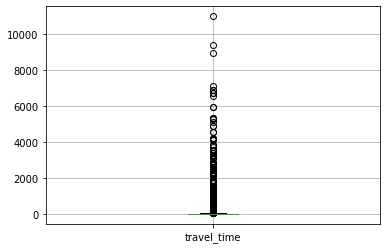

In [32]:
df_non_extreme_travel_times = usage_df.loc[usage_df['travel_time'] > 0]
df_non_extreme_travel_times.boxplot(column='travel_time')

Cuartiles: **Q1 = 7.833333, Q3 = 17.533333**

Rango intercuartílico (RI) = Q3 - Q1 = **9,7** min

Atípicos: (Sólo hay por el lado derecho)
    - LD = Q3 + 1.5RI = 32,083333
Atípicos extremos:
    - LD = Q3 + 3RI = 46,633333

In [33]:
usage_df[usage_df['travel_time'] > 33].count()

user_type           34568
travel_time         34568
idunplug_station    34568
ageRange            34568
idplug_station      34568
unplug_hour         34568
unplug_weekday      34568
dtype: int64

In [34]:
usage_df.loc[usage_df['travel_time'] > 6000].count()

user_type           9
travel_time         9
idunplug_station    9
ageRange            9
idplug_station      9
unplug_hour         9
unplug_weekday      9
dtype: int64

Observamos que hay alrededor de 21435 valores extremos, 9 de ellos de 4 días de duración (posiblemente debido a bicicletas perdidas o fallos en el sistema). Para que nuestro box-plot sea explicativo vamos a considerar sólo trayectos por debajo de una hora de duración:

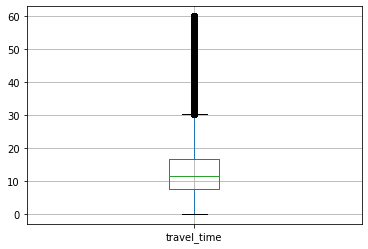

In [35]:
df_non_extreme_travel_times = usage_df.loc[usage_df['travel_time'] < 60]
df_non_extreme_travel_times.boxplot(column='travel_time')

#### Análisis de trayectos con la misma estación de desenganche y enganche

In [36]:
usage_df['idunplug_station'].unique().size
#180 valores únicos

180

In [37]:
misma_estacion = usage_df[usage_df['idunplug_station'] == usage_df['idplug_station']]
misma_estacion.count()

user_type           16336
travel_time         16336
idunplug_station    16336
ageRange            16336
idplug_station      16336
unplug_hour         16336
unplug_weekday      16336
dtype: int64

Hay 16336 casos en los que la bici se engancha y desengancha en la misma estación. Podría tratarse de las personas que cogen la bici cerca de casa para realizar actividades rutinarias para las que deben volver (por ejemplo hacer la compra).

In [38]:
misma_estacion['idunplug_station'].value_counts()

135     363
6       355
64      331
175     298
58      280
       ... 
112      18
144      17
173      16
85       12
2008      6
Name: idunplug_station, Length: 180, dtype: int64

In [39]:
misma_estacion['user_type'].value_counts()

1    9083
3    6721
2     532
Name: user_type, dtype: int64

6721 de 26314 empleados cogen y dejan la bici en la misma estación.

La estación en la que más ocurre que se engancha y desengancha la bici en ella misma es la 135, con 363 casos.

Analizamos los tiempos de trayecto de los usuarios 1 y 2:

In [40]:
misma_estacion = misma_estacion.loc[(usage_df.user_type == 1) | (usage_df.user_type == 2)]

In [41]:
misma_estacion['user_type'].value_counts()

1    9083
2     532
Name: user_type, dtype: int64

In [64]:
misma_estacion.groupby('user_type')['travel_time'].describe()

,count,mean,std,min,25%,50%,75%,max
user_type,,,,,,,,
1,9083.0,41.356767,42.176580,5.000000,15.483333,27.366667,52.391667,352.933333
2,532.0,67.537688,57.662148,5.083333,27.200000,56.566667,87.791667,337.066667


El tiempo mínimo de trayecto es de 5 minutos, y el mayor de casi 6 horas.

La media de tiempo de trayecto para los usuarios 1 y 2 que cogen y dejan la bici en la misma estación es de 42 y 68 minutos, respectivamente. Mientras que los valores máximos, en ambos casos, superan las 5 horas. (Habría que analizar los valores extremos y ver si pudiese tratarse de valores erróneos).

## Uso de bicis por hora

In [43]:
time_list = usage_df['unplug_hour'].value_counts()
time_counts = pd.DataFrame(time_list)
time_counts.sort_index(inplace=True)
time_counts

,unplug_hour
0,13731
1,10012
2,7097
3,4343
4,3141
5,2321
6,3796
7,12704
8,27859
9,25339


Vemos que la hora punta son las 19:00, y la de menos ocupación las 05:00

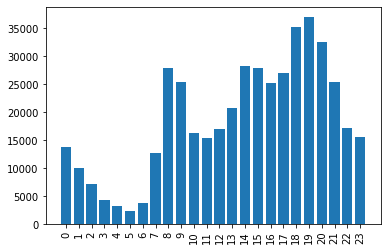

In [44]:
# Make a fake dataset:
time = time_counts['unplug_hour']
bars = time_counts.index
y_pos = np.arange(len(bars))
 
# Create bars
plt.bar(y_pos, time)
 
# Create names on the x-axis
plt.xticks(y_pos, bars, rotation=90)

# Show graphic
plt.show()

In [45]:
usage_df['unplug_hour'].describe()

count    450811.000000
mean         14.107489
std           5.966935
min           0.000000
25%          10.000000
50%          15.000000
75%          19.000000
max          23.000000
Name: unplug_hour, dtype: float64

## Uso según el tipo de usuario

- 1: usuario anual
- 2: usuario ocasional
- 3: trabajador de la empresa

Vemos que el grupo que de más frecuencia de uso es el usuario anual. Sin embargo, este es el que realiza los trayectos de menor duración de media (15 minutos), frente a los usuarios ocasionales (40 minutos). Esto puede deberse a que el primer grupo se constituya por la gente que ba en bici al trabajo, hacer la compra, actividades rutinarias.

In [46]:
round(((pd.crosstab(index=usage_df["user_type"],columns="count").sort_values(by='count', ascending=False))/usage_df.user_type.count())*100, 2)

col_0,count
user_type,
1,92.89
3,5.84
2,1.27


In [47]:
file = pd.DataFrame(usage_df.groupby(['user_type'])['travel_time'].mean())
file.head()

,travel_time
user_type,
1,14.999532
2,41.094281
3,47.697213


# Conclusiones y más limpieza

- Quitar las filas menos significativas (valores extremos, errores, empleados)

# Correlación de variables

In [48]:
usage_df.corr()

,user_type,travel_time,idunplug_station,ageRange,idplug_station,unplug_hour,unplug_weekday
user_type,1.000000,0.135024,0.059032,0.008933,0.049995,-0.055964,0.015956
travel_time,0.135024,1.000000,0.012026,-0.020478,0.017147,-0.003459,0.023412
idunplug_station,0.059032,0.012026,1.000000,-0.007310,0.104587,0.013753,-0.030057
ageRange,0.008933,-0.020478,-0.007310,1.000000,-0.011310,-0.012859,-0.052449
idplug_station,0.049995,0.017147,0.104587,-0.011310,1.000000,-0.036639,-0.020561
unplug_hour,-0.055964,-0.003459,0.013753,-0.012859,-0.036639,1.000000,-0.060701
unplug_weekday,0.015956,0.023412,-0.030057,-0.052449,-0.020561,-0.060701,1.000000


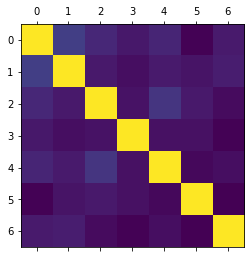

In [49]:
plt.matshow(usage_df.corr())

- Número de veces que un usuario es propenso a coger la bici en el mismo día
- Estación de destino en función a todo lo demás (age range, tipo, plug station, travel time...)
- Qué hacer con los ZIP CODES:
    - filtrar los de madrid (28xxx) y ver si el codigo postal del usuario se corresponde con el de la estación


In [50]:
#usage_df.to_csv('cleanData_v3.csv')